In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from tqdm import tqdm

In [6]:
df_ds[se_label].unique().shape

(10184,)

In [8]:
df_ds.STITCH.unique().shape

(639,)

In [3]:
se_label = 'Individual Side Effect'

# Drug-Target
df_dt = pd.read_csv('../data/bio-decagon-targets.csv').rename(columns={'STITCH': 'drug', 'Gene': 'gene'})
df_dt = df_dt.rename(columns={'drug': 'STITCH'})

# Drug-Side Effect
df_ds = pd.read_csv('../data/bio-decagon-mono.csv') # drug - side-effect

# Drug ID mapper
df = pd.read_csv('../data/drugbank.txt', sep='\t')
df = df.drop_duplicates(subset=['DrugbankID', 'CID'], keep='first')

did_to_cid = {row.DrugbankID: row.CID for _, row in df[['DrugbankID', 'CID']].iterrows() if not pd.isnull(row.CID)}
cid_to_did = {row.CID: row.DrugbankID for _, row in df[['DrugbankID', 'CID']].iterrows() if not pd.isnull(row.CID)}

df_ds['compound'] = df_ds.STITCH.apply(lambda x: cid_to_did.get(x, None))
df_dt['compound'] = df_dt.STITCH.apply(lambda x: cid_to_did.get(x, None))

all_drugs = list(set(df_ds.STITCH.unique().tolist()).union(df_dt.STITCH.unique()))
all_targets = list(set(df_dt.gene.tolist()))
n_drugs = len(all_drugs)
n_targets = len(all_targets)
pp_idx_mapper = {p: all_targets.index(p) for p in all_targets}
all_se = list(df_ds[se_label].unique())
all_drugs_did = list(set(df_ds.compound.unique().tolist()).union(df_dt.compound.unique()))

se_idx_mapper = {se: i for i, se in enumerate(all_se)}
df_ds['se_idx'] = df_ds[se_label].apply(lambda x: se_idx_mapper[x])

# Drug Similarity
df_dsim = pd.read_csv('../data/similarity.csv', index_col=0)
df_dsim['STITCH0'] = df_dsim.compound0.apply(lambda x: did_to_cid.get(x, None))
df_dsim['STITCH1'] = df_dsim.compound1.apply(lambda x: did_to_cid.get(x, None))
print(df_ds.shape)

(174977, 5)


In [22]:
df_ds[se_label].unique().shape

(10184,)

In [37]:
se_with_one_drug = set(df_ds.groupby('Individual Side Effect').count()[
    df_ds.groupby('Individual Side Effect').count().STITCH>30].index.unique())#.unique()
# for d in all_drugs:
len(se_with_one_drug)

1626

<AxesSubplot: >

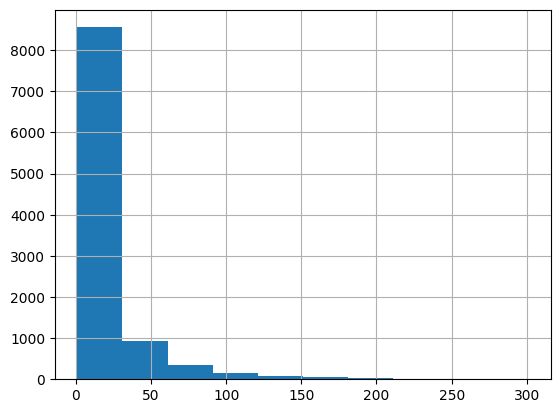

In [4]:
# filtered_se = df_ds.groupby('Individual Side Effect').count()[
#     df_ds.groupby('Individual Side Effect').count().STITCH>10].index.unique()#.unique()
# df_ds = df_ds[df_ds[se_label].isin(filtered_se)]
# df_ds.shape

In [7]:
k = df_ds.groupby('Individual Side Effect').count()[
    df_ds.groupby('Individual Side Effect').count().STITCH>10].index


In [133]:
df_ds[se_label].unique().shape

(3637,)

In [13]:
df_ds.shape

(174977, 5)

In [26]:
from typing import Set

def jaccard(s1: Set, s2: Set):
    return len(s1.intersection(s2))/len((s1.union(s2)))

jaccard({1,2,3,4}, {1,2})

0.5

In [19]:
set(df_dt[df_dt.STITCH=='CID003062316'].gene.unique()).intersection(
    set(df_dt[df_dt.STITCH=='CID000005245'].gene.unique()))

set()

In [267]:
drugs = df_ds.STITCH.unique()[:20]

In [136]:
# drugs = ['CID000003488', 'CID000003961']#, 'CID000005245', 'CID003062316']

In [268]:
# df_dt_ft = df_dt[df_dt.STITCH.isin(drugs)]
# df_ds_ft = df_ds[df_ds.STITCH.isin(drugs)]
# df_ds_ft = df_ds_ft[df_ds_ft.se_idx%2==0]
# df_dt_ft = df_dt_ft[~df_dt_ft.compound.isna()]
# df_ds_ft.shape

(1860, 5)

In [223]:
df_dt_ft = df_dt_ft[~df_dt_ft.compound.isna()]

,STITCH,gene,compound
10234,CID000003937,1636,None


In [ ]:
df_

In [222]:
df_dt[df_dt.compound.isna()]

,STITCH,gene,compound
521,CID000000271,127018,None
522,CID000000271,56985,None
523,CID000000271,55616,None
524,CID000000271,55617,None
525,CID000000271,55347,None
...,...,...,...
18366,CID000001206,6529,None
18367,CID000001206,11254,None
18368,CID000001206,388662,None
18369,CID000001206,6538,None


In [333]:
a = np.array([1,2,3])
b = np.array([4,5,6])

np.concatenate([a, b])

array([1, 2, 3, 4, 5, 6])

In [24]:
from scipy.linalg import fractional_matrix_power
class DSERandomWalk:
    
    def __init__(self, df_ds, df_dsim, df_dt, lmd=0.5, w_d=0.7):
        self.lmd = lmd
        self.w_d = w_d
        self.df_ds = df_ds
        self.df_dsim = df_dsim
        self.df_dt = df_dt
        all_drugs = list(set(df_ds[df_ds.compound.notna()].STITCH.unique().tolist()).intersection(
    df_dt[df_dt.compound.notna()].STITCH.unique()))
        self.all_drugs = all_drugs
        
#         all_drugs = list(set(df_dsim['STITCH0'].unique()).union(set(df_dsim['STITCH1'].unique())))
#         self.all_drugs = list(set(df_ds.STITCH.unique().tolist()).union(df_dt.STITCH.unique()))
        self.all_targets = list(set(df_dt.gene.tolist()))
        self.n_drugs = len(all_drugs)
        self.n_targets = len(all_targets)
        all_se = list(df_ds[se_label].unique())
        all_drugs_did = list(set(df_ds.compound.unique().tolist()).union(df_dt.compound.unique()))
        self.all_se = all_se
        
        # side effect similarity
        print('side effect similarity')
        S_s = self.ss_similarity_matrix(df=df_ds, all_se=all_se)
        print('drug shared target similarity')
        S_d_t = self.dd_target_similarity_matrix(df_dt, all_drugs=all_drugs)
        print('drug chem similarity')
        S_d_c = self.dd_chem_similarity_matrix(all_drugs=all_drugs, df_sim=df_dsim)
        S_d = w_d*S_d_c + (1-w_d)*S_d_t


        print('ds adjacency matrix')
        A_ds = self.ds_adj_matrix(df_ds, all_se, all_drugs)
    
        print('Mss')
        self.M_ss = self.ss_transition_matrix(S_s, A_ds, lmd=lmd)
        print('M_sd')
        self.M_sd = self.sd_transition_matrix(df=df_ds, all_drugs=all_drugs, all_se=all_se, A=A_ds, lmd=lmd)
        print('Mds')
        self.M_ds = self.ds_transition_matrix(df=df_ds, all_drugs=all_drugs, all_se=all_se, A=A_ds, lmd=lmd)
        print('Mdd')
        self.M_dd = self.dd_transition_matrix(S_d, A_ds, lmd=lmd)
        
        self.Ms = np.concatenate([self.M_ss, self.M_sd], axis=1)
        self.Md = np.concatenate([self.M_ds, self.M_dd], axis=1)
        self.M = np.concatenate([self.Ms, self.Md], axis=0)
        self.p_mapping = np.concatenate([self.all_se, self.all_drugs])
    
    def ds_adj_matrix(cls, df, all_se, all_drugs): 
        """Drug-Side Effect Adjacency Matrix"""
        n_drugs = len(all_drugs)
        n_se = len(all_se) 
        A = np.zeros((n_drugs, n_se), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n_drugs)):
            nbrs = df[df.STITCH==all_drugs[i]][se_label].unique()
            nbrs = [all_se.index(nb) for nb in nbrs]
            for j in nbrs:
                A[i, j] = 1
        return A   
    
    def dd_chem_similarity_matrix(cls, all_drugs, df_sim):
        """Drug-Drug similarity matrix based on chemical structures"""
        n = len(all_drugs)
        M = np.zeros((n, n), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n-1)):
            d1 = all_drugs[i]
            poi = df_sim[(df_sim.STITCH0==d1)|(df_sim.STITCH1==d1)]
            if not poi.shape[0]:
                continue
            for j in range(i+1, n):
                d2 = all_drugs[j]
                ss = poi[(poi.STITCH0==d2)|(poi.STITCH1==d2)]
                if ss.shape[0]:
                    s = ss.iloc[0].similarity
                    M[i, j] = s
                    M[j, i] = s

        # normalize
        norm_terms = np.sum(M, axis=1)
        norm_terms[np.where(norm_terms == 0)] = 1
        D = np.diag(norm_terms)
        D_sq = fractional_matrix_power(D, -1/2)
        S = np.matmul(np.matmul(D_sq, M), D_sq)

        return S

    def dd_target_similarity_matrix(cls, df_dt, all_drugs):
        """Drug-Drug similarity based on shared targets"""
        n = len(all_drugs)
        M = np.zeros((n, n), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n-1)):
            d1 = all_drugs[i]
            targets_i = set(df_dt[df_dt.STITCH==d1].gene)
            if not len(targets_i):
                continue
            for j in range(i+1, n):
                d2 = all_drugs[j]
                targets_j = set(df_dt[df_dt.STITCH==d2].gene)
                if not len(targets_i):
                    continue
                jc = jaccard(targets_i, targets_j)
                M[i, j] = jc
                M[j, i] = jc
        norm_terms = np.sum(M, axis=1)  
        norm_terms[np.where(norm_terms == 0)] = 1
        D = np.diag(norm_terms)
        D_sq = fractional_matrix_power(D, -1/2)
        S = np.matmul(np.matmul(D_sq, M), D_sq)
        return S

    def ss_similarity_matrix(cls, df, all_se):
        """Side Effect-Side Effect similarity based on shared drugs"""
        n = len(all_se)
        M = np.zeros((n, n), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n-1)):
            se1 = all_se[i]
            drugs_i = set(df[df[se_label]==se1].STITCH)
            if not len(drugs_i):
                continue
            for j in range(i+1, n):
                se2 = all_se[j]
                drugs_j = set(df[df[se_label]==se2].STITCH)
                if not len(drugs_i):
                    continue
                jc = jaccard(drugs_i, drugs_j)
                M[i, j] = jc
                M[j, i] = jc
        norm_terms = np.sum(M, axis=1)  
        norm_terms[np.where(norm_terms == 0)] = 1
        D = np.diag(norm_terms)
        D_sq = fractional_matrix_power(D, -1/2)
        S = np.matmul(np.matmul(D_sq, M), D_sq)
        return S
    
    def ss_transition_matrix(cls, S_ss, A_ds, lmd):
        norm = np.sum(S_ss, axis=1)
        sum_A_sd = np.sum(A_ds, axis=0) 
        M = np.zeros_like(S_ss)
        for i in range(S_ss.shape[0]):
            if sum_A_sd[i]:
                M[i] = S_ss[i]/norm[i] * (1-lmd)
            else:
                M[i] = S_ss[i]/norm[i]
        return M
    
    def dd_transition_matrix(cls, S_d, A_ds, lmd=0.5):
        norm = np.sum(S_d, axis=1)
        row_sum_A_ds = np.sum(A_ds, axis=1)
        M = np.zeros_like(S_d)
        for i in range(S_d.shape[0]):
            if row_sum_A_ds[i]:
                M[i] = S_d[i]/norm[i] * (1-lmd)
            else:
                M[i] = S_d[i]/norm[i]
        return M
    
    def ds_transition_matrix(cls, df, all_drugs, all_se, A, lmd):
        """Drug-Side Effect transition matrix"""
        n_drugs = len(all_drugs)
        n_se = len(all_se)
        M = np.zeros((n_drugs, n_se), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n_drugs)):
            n_nbrs = np.sum(A[i])
            if not n_nbrs:
                continue
            for j in range(n_se):
                M[i,j] = A[i, j]/n_nbrs * (lmd)
        return M
    
    def sd_transition_matrix(cls, df, all_drugs, all_se, A, lmd):
        """Side Effect-Drug transition matrix"""
        n_drugs = len(all_drugs)
        n_se = len(all_se)
        M = np.zeros((n_se, n_drugs), dtype=np.float32)
        adj_lst = []
        for i in tqdm(range(n_se)):
            n_nbrs = np.sum(A[:,i])
            if not n_nbrs:
                continue
            for j in range(n_drugs):
                M[i,j] = A[j, i]/n_nbrs * (lmd)
        return M


In [46]:
!ls ../data/pickles

rw.pickle


In [48]:
import pickle

with open('../data/pickles/rw.pickle', 'rb') as f:
    rw = pickle.load(f)


In [50]:
Mt = rw.M.T
p0 = np.zeros(Mt.shape[0])
p0[-1] = 1
p = (0.8)*np.matmul(Mt, p0)+0.2*p0
print(p[-10:])
for i in range(20):
    p = (0.8)*np.matmul(Mt, p)+0.2*p0
    print(p[-10:])

[0.00172364 0.00134036 0.00102994 0.00150387 0.00143151 0.00190319
 0.00149286 0.00065895 0.01368124 0.2       ]
[0.00187224 0.00140472 0.00130582 0.0014961  0.00143632 0.00171449
 0.00302119 0.00102609 0.00537231 0.20486058]
[0.00171778 0.00133795 0.00126223 0.00149345 0.00170701 0.00175888
 0.0028169  0.00110618 0.00450866 0.20216086]
[0.00171867 0.00134015 0.00126106 0.00149489 0.00171939 0.00175846
 0.00283993 0.00110151 0.00437834 0.20214667]
[0.00171597 0.00134024 0.00125922 0.00149564 0.00172311 0.00175957
 0.00283726 0.0011002  0.00436077 0.20212887]
[0.00171579 0.00134032 0.00125905 0.00149578 0.00172352 0.00175965
 0.00283754 0.00109993 0.00435859 0.20212814]
[0.00171572 0.00134034 0.00125899 0.00149582 0.0017236  0.00175968
 0.00283748 0.00109986 0.00435827 0.20212792]
[0.00171571 0.00134034 0.00125898 0.00149583 0.00172361 0.00175969
 0.00283748 0.00109985 0.00435823 0.2021279 ]
[0.00171571 0.00134034 0.00125898 0.00149583 0.00172361 0.00175969
 0.00283748 0.00109985 0.0043

In [102]:
idx = np.argsort(-p[:len(rw.all_se)])
top_ranked = set([rw.p_mapping[i] for i in idx[:120]])
len(y.intersection(top_ranked))

114

In [57]:
len(y.intersection(rw.p_mapping[:100]))

'CID000005978'

In [76]:
y = set(df_ds[df_ds.STITCH=='CID000005978']['Individual Side Effect'].unique()) # 398
len(y.intersection(set(rw.p_mapping))), len(rw.all_se)


(165, 703)

In [92]:
rw.p_mapping[idx[0]]

'C0042023'

In [90]:
p[idx[0]]

0.00026637788224586804

In [88]:
p[:703]

array([0.0009785 , 0.00152737, 0.00092202, 0.00093094, 0.00039331,
       0.0002805 , 0.00047268, 0.00034249, 0.00044904, 0.00073297,
       0.00057929, 0.00047257, 0.00033546, 0.00074637, 0.00102276,
       0.00084369, 0.00029676, 0.00048335, 0.00091078, 0.00122476,
       0.00060707, 0.00040139, 0.00099364, 0.00077313, 0.00032799,
       0.00039336, 0.00035532, 0.00059517, 0.00035615, 0.00051716,
       0.00115794, 0.00061895, 0.00081963, 0.00044934, 0.00048884,
       0.00053938, 0.00033665, 0.00106211, 0.00104038, 0.00113148,
       0.00036806, 0.00058831, 0.00081631, 0.0013297 , 0.00050067,
       0.00052706, 0.00061158, 0.00041685, 0.0005793 , 0.00049597,
       0.00048833, 0.00042956, 0.00040074, 0.00095823, 0.00075652,
       0.00093105, 0.00033987, 0.00085004, 0.00094187, 0.0010165 ,
       0.00110126, 0.00034604, 0.0006972 , 0.00143233, 0.00144174,
       0.00056571, 0.00108874, 0.0003441 , 0.00085862, 0.00088319,
       0.00110219, 0.00056304, 0.00064593, 0.00114824, 0.00051

In [86]:
rw.M[942,:][:703]

array([0.0030303, 0.0030303, 0.0030303, 0.0030303, 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.0030303, 0.       , 0.       ,
       0.0030303, 0.0030303, 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.0030303, 0.       , 0.0030303, 0.       , 0.       , 0.       ,
       0.       , 0.0030303, 0.0030303, 0.0030303, 0.       , 0.       ,
       0.       , 0.0030303, 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.0030303, 0.       , 0.0030303,
       0.0030303, 0.       , 0.       , 0.0030303, 0.0030303, 0.       ,
       0.0030303, 0.       , 0.0030303, 0.0030303, 0.0030303, 0.       ,
       0.       , 0.0030303, 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 

In [84]:
np.argsort(rw.M[942,:][:703])

array([351, 429, 430, 431, 432, 434, 435, 436, 437, 438, 439, 440, 441,
       443, 444, 445, 428, 447, 427, 424, 405, 409, 410, 411, 412, 413,
       414, 415, 416, 418, 419, 420, 421, 422, 423, 426, 404, 448, 450,
       479, 480, 481, 482, 483, 484, 485, 487, 488, 490, 492, 494, 495,
       497, 498, 478, 449, 475, 471, 452, 453, 454, 455, 458, 459, 460,
       461, 462, 463, 464, 465, 467, 468, 470, 472, 403, 402, 401, 335,
       336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 347, 348, 349,
       350, 334, 701, 333, 331, 310, 311, 312, 313, 314, 315, 317, 318,
       319, 322, 325, 326, 327, 329, 330, 332, 353, 354, 356, 384, 385,
       386, 388, 389, 390, 391, 392, 393, 394, 395, 396, 398, 399, 400,
       383, 382, 380, 379, 357, 358, 359, 360, 362, 364, 365, 500, 366,
       371, 372, 373, 374, 375, 377, 378, 369, 309, 501, 503, 634, 635,
       636, 637, 639, 640, 641, 642, 643, 644, 645, 646, 648, 649, 650,
       632, 651, 631, 629, 609, 610, 611, 612, 614, 615, 616, 61

In [98]:
len(y.intersection(rw.p_mapping[:100]))

28

In [56]:
for i in idx:
    print(rw.p_mapping[i])

C1262281
C0009460
C0854029
C0854506
C0026916
C1608945
C0948649
C0741921
C0036982
C0852280
C1096652
C0005956
C0743733
C0341503
C1869066
C0853226
C0158889
C0555120
C0860689
C0854794
C0035273
C0852810
C2607947
C0842860
C0151747
C0853068
C0852958
C0577730
C1096514
C0876991
C0948279
C1167654
C0187830
C0858342
C0240225
C0010073
C0347621
C1964007
C0442951
C1142137
C0853023
C1141926
C0549357
C1112615
C0151577
C0156714
C0948296
C0852879
C0851043
C0851869
C0847978
C1167745
C0438142
C0919768
C0191342
C0151785
C0339916
C2363825
C0438216
C0243001
C0549395
C0151313
C0080032
C0034088
C1536013
C0263008
C2609421
C0152972
C0270549
C0278987
C0852020
C0188602
C0026644
C0851560
C0220994
C0542313
C0004364
C1096559
C0021080
C0154476
C0877011
C0522351
C0855429
C0241148
C0241136
C1619705
C0042018
C0455204
C0232766
C0919980
C0948361
C0235234
C0851564
C0158439
C0149699
C0264714
C0948374
C0034074
C0861111
C0239735
C0034628
C1142300
C0876998
C0595900
C0151740
C0877314
C0855335
C1639520
C0522776
C0238246
C0520887
C

In [44]:
se_with_one_drug = set(df_ds.groupby('Individual Side Effect').count()[
    df_ds.groupby('Individual Side Effect').count().STITCH>60].index.unique())#.unique()
# for d in all_drugs:
len(se_with_one_drug)
#1: remove side effect with connections to drugs less than some threshold
#2: remove drugs from input only

703

In [45]:
df_ds.STITCH.unique().shape

(639,)

In [ ]:

for drug in all_drugs:
    df_ds[df_ds.STITCH==drug]

In [49]:
# rw2 = DSERandomWalk(df_ds=df_ds[df_ds[se_label].isin(all_se[:800])], df_dsim=df_dsim,
#                     df_dt=df_dt[df_dt.STITCH.isin(all_drugs[:200])])

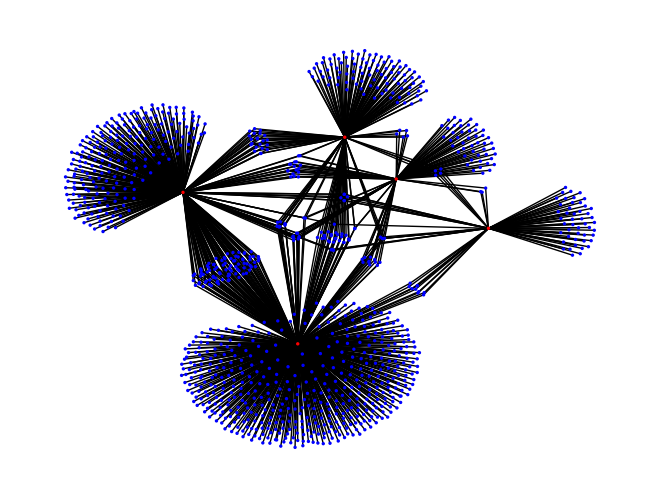

In [336]:
poi = df_ds[df_ds.STITCH.isin(['CID000003386', 'CID003062316', 'CID000004739','CID000004543','CID000077992',])]
poi = poi[['STITCH', 'Individual Side Effect']]
Gp = nx.Graph()
Gp.add_edges_from(list(poi.itertuples(index=False, name=None)))
nx.draw(Gp, node_size=2, node_color= ['red' if node.startswith('CID') else 'blue' for node in Gp.nodes])

In [337]:
filtered_ses = df_ds_ft.groupby('Individual Side Effect').count()[
    df_ds_ft.groupby('Individual Side Effect').count().STITCH>1].index.unique()#.unique()
df_ds_ft = df_ds_ft[df_ds_ft[se_label].isin(filtered_ses)]

In [382]:
df_ds.shape

(151856, 5)

In [383]:
df_ds.groupby(se_label).count()

,STITCH,Side Effect Name,compound,se_idx
Individual Side Effect,,,,
C0000727,45,45,24,45
C0000729,29,29,28,29
C0000733,12,12,6,12
C0000734,67,67,36,67
C0000735,36,36,19,36
...,...,...,...,...
C2979982,41,41,34,41
C2981158,22,22,19,22
C3203358,19,19,17,19


In [378]:
rw2 = DSERandomWalk(df_ds=df_ds, df_dsim=df_dsim, df_dt=df_dt)

  0%|                                                                                                                                                                   | 1/3636 [01:35<96:03:54, 95.14s/it]


KeyboardInterrupt: 

In [339]:
rw = DSERandomWalk(df_ds=df_ds_ft, df_dsim=df_dsim, df_dt=df_dt_ft)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 112.87it/s]


In [385]:
df_ds_ft.STITCH.unique()

array(['CID003062316', 'CID000003117', 'CID000003114', 'CID000003730',
       'CID000003736', 'CID000003734', 'CID000002646', 'CID000028112',
       'CID004183806', 'CID000002462', 'CID000005381', 'CID000125889',
       'CID000005245', 'CID000004034', 'CID000003937', 'CID005362070',
       'CID000003121', 'CID000003382', 'CID000003381', 'CID000003386'],
      dtype=object)

In [341]:
def random_walk(rw):
    p0 = np.zeros(len(rw.M))
    p0[-1] = 1
    p = (0.8)*np.matmul(Mt, p0)+0.2*p0
    for i in range(20):
        p = (0.8)*np.matmul(Mt, p)+0.2*p0
        print(p)
    return p
    

In [346]:
rw.p_mapping[-1]

'CID000003114'

In [355]:
df_ds[df_ds[se_label]=='C0854696'].STITCH

1363      CID004183806
2984      CID005362070
31751     CID000068740
34649     CID000004885
48307     CID006447131
57282     CID000005538
63592     CID000004509
98241     CID000001065
111417    CID000004674
125721    CID000003308
133986    CID000005095
138821    CID000002812
145572    CID000004200
148644    CID000005650
158791    CID000667490
164497    CID000003902
173652    CID000005376
Name: STITCH, dtype: object

In [356]:
for i in np.argsort(p[:len(rw.all_se)]):
    se = rw.p_mapping[i]
    if 'CID000003114' in df_ds[df_ds[se_label]==se].STITCH:
        print(i, se)
#     print(se)
#     print('CID000003114' in df_ds[df_ds[se_label]==se].STITCH)

In [370]:
df_ds_ft[df_ds_ft.STITCH=='CID000003114'][se_label].unique().shape

(46,)

In [377]:
set(sorted_se[:500]).intersection(df_ds_ft[df_ds_ft.STITCH=='CID000003114'][se_label].unique())

{'C0006110',
 'C0007166',
 'C0007273',
 'C0010520',
 'C0011946',
 'C0012739',
 'C0018794',
 'C0023976',
 'C0026961',
 'C0037274',
 'C0037384',
 'C0042023',
 'C0149504',
 'C0150450',
 'C0151539',
 'C0151578',
 'C0151814',
 'C0151878',
 'C0151905',
 'C0155387',
 'C0155895',
 'C0156439',
 'C0220994',
 'C0235475',
 'C0236037',
 'C0239134',
 'C0241237',
 'C0262469',
 'C0277884',
 'C0302809',
 'C0521849',
 'C0580413',
 'C0700590',
 'C0852913',
 'C0853149',
 'C0854133',
 'C0855625',
 'C0858635',
 'C0869219',
 'C0948353',
 'C0948605',
 'C1112386',
 'C1328321',
 'C1536001',
 'C1720775',
 'C2242996'}

In [369]:
len(set(sorted_se).intersection(df_ds_ft[df_ds_ft.STITCH=='CID000003114'][se_label].unique()))

46

In [365]:
sorted_se = [rw.p_mapping[i] for i in np.argsort(p[:len(rw.all_se)])]

In [357]:
df_ds[df_ds.STITCH==rw.all_drugs[-1]]

,STITCH,Individual Side Effect,Side Effect Name,compound,se_idx
353,CID000003114,C0341697,renal impairment,DB00280,347
354,CID000003114,C0035232,diaphragmatic paralysis,DB00280,348
355,CID000003114,C0855476,blood lactate dehydrogenase decreased,DB00280,349
356,CID000003114,C0162119,Haemoglobin decreased,DB00280,350
359,CID000003114,C0854029,blood creatine increased,DB00280,353
...,...,...,...,...,...
500,CID000003114,C0232197,cardiac fibrillation,DB00280,467
501,CID000003114,C0700590,Hyperhidrosis,DB00280,468
502,CID000003114,C0742906,c-reactive protein increased,DB00280,469
503,CID000003114,C1168207,haemodialysis,DB00280,345


In [351]:
np.argsort(p[:len(rw.all_se)])

array([283, 311, 358, 288, 284, 305, 427, 426, 438, 436, 329, 209, 204,
       290, 239, 379, 384, 374, 385, 341, 334, 324, 319, 219, 215, 294,
       233, 240, 260, 175, 151, 206, 153, 249, 270, 254, 176, 281, 296,
       299, 252, 217, 205, 203, 226, 264, 184, 261, 146, 325, 333, 320,
       361, 373, 367, 363, 378, 247, 253, 370, 181, 231, 198, 415, 417,
       418, 420, 422, 189, 160, 414, 232, 241, 234, 229, 212, 237, 143,
       165, 157, 276, 278, 190, 150, 263, 148, 201, 313, 317, 372, 359,
       376, 141, 185, 154, 162, 200, 202, 177, 191, 166, 142, 145, 159,
       149, 396, 295, 300, 285, 301, 292, 327, 375, 380, 365, 335, 321,
       323, 315, 392, 395, 398, 357, 430, 318, 199, 293, 280, 238, 439,
       440, 211, 235, 248, 236, 220, 368, 282, 289, 399, 391, 337, 312,
       314, 419, 424, 413, 377, 381, 371, 245, 207, 269, 262, 332, 193,
       287, 182, 158, 437,  51,  29,  60, 224, 291, 326, 397, 188, 286,
        23,  10, 225, 304, 257, 164, 339, 328, 267, 272, 421, 41

In [342]:
p = random_walk(rw)

[4.06233585e-03 4.93154869e-04 9.65182916e-04 7.91700359e-04
 1.19274413e-03 7.98140232e-04 1.23647321e-03 9.20436006e-04
 8.82526487e-04 1.24053912e-03 5.09026667e-04 1.20082857e-03
 7.98140232e-04 3.69685305e-03 1.40998694e-03 1.17439591e-03
 1.47247223e-03 8.30581530e-04 3.69685305e-03 8.55617807e-04
 3.32451833e-03 6.08477598e-04 1.18772419e-03 5.09026667e-04
 1.06350170e-03 8.30581530e-04 5.47211407e-04 1.10110924e-03
 7.98140232e-04 5.35988026e-04 8.61977884e-04 1.44767865e-03
 6.02220375e-04 1.10981857e-03 8.13140285e-04 1.06350170e-03
 5.98027151e-04 7.98140232e-04 1.13648929e-03 1.31260269e-03
 7.98140232e-04 1.07566298e-03 1.87382718e-03 1.20082857e-03
 1.06734969e-03 3.81109798e-03 1.16128014e-03 6.50037185e-04
 1.82702220e-03 8.13140285e-04 9.62330955e-04 5.35988026e-04
 9.57576718e-04 1.07539640e-03 1.13060191e-03 5.42274662e-04
 1.38123240e-03 6.17679945e-04 5.63426681e-04 8.30581530e-04
 5.05390577e-04 1.06350170e-03 1.07654055e-03 9.74834474e-04
 9.75021209e-04 6.502159

In [244]:
rw.M_dd

array([[0.        , 0.03390909, 0.04849135, 0.15139642, 0.0142734 ,
        0.01311041, 0.17774574, 0.06107355],
       [0.03462651, 0.        , 0.09715159, 0.05353767, 0.11636536,
        0.0687112 , 0.06023331, 0.06937438],
       [0.04844612, 0.09505001, 0.        , 0.05611885, 0.07854367,
        0.06653354, 0.07297366, 0.08233418],
       [0.17765412, 0.06152145, 0.06591339, 0.        , 0.02457917,
        0.04824017, 0.05069157, 0.07140012],
       [0.01131928, 0.09036965, 0.0623459 , 0.01661113, 0.        ,
        0.04664444, 0.20233071, 0.07037887],
       [0.01698479, 0.08717237, 0.08627596, 0.05325901, 0.07619954,
        0.        , 0.08229586, 0.09781248],
       [0.11343448, 0.0376435 , 0.0466141 , 0.02756906, 0.16282316,
        0.04053965, 0.        , 0.071376  ],
       [0.05568766, 0.06194586, 0.07514346, 0.0554811 , 0.08092014,
        0.06884243, 0.10197933, 0.        ]], dtype=float32)

In [302]:
rw.M_ss

array([[0.        , 0.00136368, 0.00182867, ..., 0.00082024, 0.00170532,
        0.00170532],
       [0.00157325, 0.        , 0.00306481, ..., 0.00302436, 0.        ,
        0.        ],
       [0.00247387, 0.00359385, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00225544, 0.00720835, 0.        , ..., 0.        , 0.01092633,
        0.01092633],
       [0.00230659, 0.        , 0.        , ..., 0.00537468, 0.        ,
        0.01523746],
       [0.00230659, 0.        , 0.        , ..., 0.00537468, 0.01523746,
        0.        ]], dtype=float32)

In [306]:
G = nx.from_numpy_matrix(rw.M_ss[:10, :10])


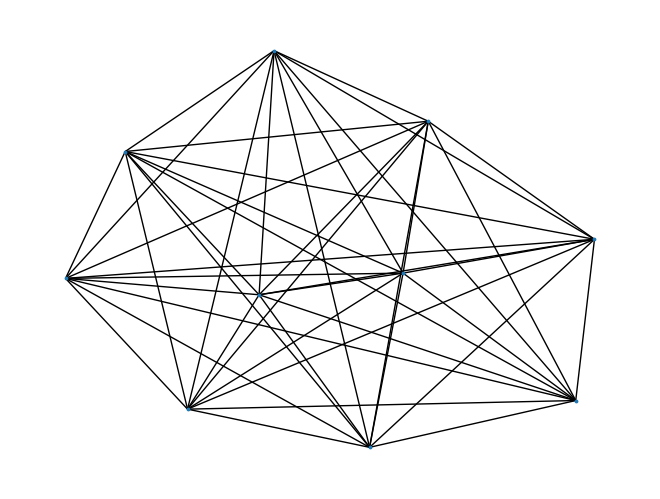

In [308]:
nx.draw(G, node_size=3)

In [245]:
M

array([[0.        , 0.00136368, 0.00182867, ..., 0.        , 0.08333334,
        0.08333334],
       [0.00157325, 0.        , 0.00306481, ..., 0.        , 0.        ,
        0.        ],
       [0.00247387, 0.00359385, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.08229586,
        0.09781248],
       [0.00393701, 0.        , 0.        , ..., 0.04053965, 0.        ,
        0.071376  ],
       [0.01086957, 0.        , 0.        , ..., 0.06884243, 0.10197933,
        0.        ]], dtype=float32)

In [256]:
Mt = M.T
p0 = np.zeros(len(M))
# p = (0.8)*np.matmul(Mt, p0)+0.2*p0
p0[-1] = 1

In [257]:
M

array([[0.        , 0.00136368, 0.00182867, ..., 0.        , 0.08333334,
        0.08333334],
       [0.00157325, 0.        , 0.00306481, ..., 0.        , 0.        ,
        0.        ],
       [0.00247387, 0.00359385, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.08229586,
        0.09781248],
       [0.00393701, 0.        , 0.        , ..., 0.04053965, 0.        ,
        0.071376  ],
       [0.01086957, 0.        , 0.        , ..., 0.06884243, 0.10197933,
        0.        ]], dtype=float32)

In [258]:
p = (0.8)*np.matmul(Mt, p0)+0.2*p0
p

array([0.00869565, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00869565, 0.        ,
       0.        , 0.        , 0.        , 0.00869565, 0.        ,
       0.00869565, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00869565, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00869565, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00869

In [210]:
len(M)

461

In [206]:
Mt.shape

(461, 461)

In [259]:
np.sum(M, axis=1)

array([0.99999994, 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 1.0000001 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.0000001 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.0000001 , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.     

In [255]:
M

array([[0.        , 0.00136368, 0.00182867, ..., 0.        , 0.08333334,
        0.08333334],
       [0.00157325, 0.        , 0.00306481, ..., 0.        , 0.        ,
        0.        ],
       [0.00247387, 0.00359385, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.08229586,
        0.09781248],
       [0.00393701, 0.        , 0.        , ..., 0.04053965, 0.        ,
        0.071376  ],
       [0.01086957, 0.        , 0.        , ..., 0.06884243, 0.10197933,
        0.        ]], dtype=float32)

In [260]:
for i in range(20):
    p = (0.8)*np.matmul(Mt, p)+0.2*p0
    print(p[:10])

[0.00406234 0.00049315 0.00096518 0.0007917  0.00119274 0.00079814
 0.00123647 0.00092044 0.00088253 0.00124054]
[0.00446356 0.00053149 0.0008752  0.00076134 0.00107006 0.00077472
 0.00109129 0.00084832 0.00081405 0.0010587 ]
[0.0041414  0.00059397 0.00094252 0.00086506 0.00117161 0.00085616
 0.00122471 0.00094258 0.00089955 0.00119776]
[0.00415005 0.00060674 0.00093844 0.00087415 0.00116544 0.0008626
 0.00122317 0.00094459 0.00090003 0.00118797]
[0.00411963 0.0006144  0.00094318 0.00088631 0.00117334 0.00087197
 0.00123615 0.00095278 0.00090893 0.00120078]
[0.00411793 0.00061674 0.0009433  0.00088851 0.00117327 0.00087359
 0.00123745 0.00095401 0.0009098  0.00120107]
[0.00411482 0.00061775 0.00094366 0.00089004 0.00117389 0.00087476
 0.00123888 0.00095482 0.00091083 0.00120236]
[0.00411438 0.00061812 0.00094374 0.00089041 0.00117393 0.00087503
 0.00123918 0.00095507 0.00091101 0.00120255]
[0.00411404 0.00061826 0.00094378 0.00089061 0.00117398 0.00087518
 0.00123935 0.00095517 0.00091

In [154]:
a = np.array([[1,2,3]])
b = np.array([[1,2,3]])
np.concatenate([a,b], axis=0)

array([[1, 2, 3],
       [1, 2, 3]])

In [291]:
df_ds[se_label].unique().shape

(3637,)

In [149]:
rw.M_ss

array([[0.        , 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.        , 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.04545454, 0.        , 0.04545454, 0.04545454,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.04545454, 0.04545454, 0.        , 0.04545454,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.        ,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.        , 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454,

In [153]:
rw.M

AttributeError: 'DSERandomWalk' object has no attribute 'M'

In [150]:
rw.M_sd

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]], dtype=float32)

In [151]:
rw.M_dd

array([[0. , 0.5],
       [0.5, 0. ]], dtype=float32)

In [152]:
rw.M_ss

array([[0.        , 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.        , 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.04545454, 0.        , 0.04545454, 0.04545454,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.04545454, 0.04545454, 0.        , 0.04545454,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.        ,
        0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454, 0.04545454],
       [0.04545454, 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.        , 0.04545454, 0.04545454, 0.04545454, 0.04545454,
        0.04545454,

In [87]:
rw.M_sd

array([[1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       [1. ,

In [77]:
rw.M_dd

array([[0., 1.],
       [1., 0.]], dtype=float32)

In [73]:
a = np.array([[1., 2.], 
              [3., 4.]])
a / np.sum(a, axis=1)

array([[0.33333333, 0.28571429],
       [1.        , 0.57142857]])

In [74]:
np.sum(a, axis=1)

array([3., 7.])

In [75]:
df_dt_ft

,STITCH,gene,compound
0,CID000003488,1559,DB01016
1,CID000003488,8647,DB01016
3368,CID000003961,1269,DB00678
3369,CID000003961,124274,DB00678
3370,CID000003961,2849,DB00678
...,...,...,...
3525,CID000003961,8484,DB00678
3526,CID000003961,81491,DB00678
3527,CID000003961,83551,DB00678
3528,CID000003961,680,DB00678


In [103]:
filtered_ses = df_ds_ft.groupby('Individual Side Effect').count()[
    df_ds_ft.groupby('Individual Side Effect').count().STITCH>1].index.unique()#.unique()

In [114]:
df_ds_ft.groupby('Individual Side Effect').count()#.STITCH>1

,STITCH,Side Effect Name,compound,se_idx
Individual Side Effect,,,,
C0003838,2,2,2,2
C0009918,2,2,2,2
C0151539,2,2,2,2
C0235431,2,2,2,2
C0241237,2,2,2,2
C0333559,2,2,2,2
C0340775,2,2,2,2
C0700361,2,2,2,2
C0853149,2,2,2,2


In [96]:
df_ds_ft

,STITCH,Individual Side Effect,Side Effect Name,compound,se_idx
33015,CID000003488,C1504410,vital functions abnormal,DB01016,6112
33017,CID000003488,C0558401,skin laceration,DB01016,1704
33019,CID000003488,C0278987,lung cancer metastatic,DB01016,3722
33020,CID000003488,C0852091,bone disorder,DB01016,806
33022,CID000003488,C0231835,respiratory rate increased,DB01016,482
...,...,...,...,...,...
146842,CID000003961,C0853828,post inflammatory pigmentation change,DB00678,5420
146843,CID000003961,C0853314,soft tissue inflammation,DB00678,1916
146844,CID000003961,C0542044,incoherent,DB00678,936
146846,CID000003961,C0237322,skin turgor decreased,DB00678,2806


In [14]:
def visualize_graph(df, col1='STITCH', col2='Individual Side Effect', n=1000):
    poi = df[[col1, col2]].head(n)
    Gp = nx.Graph()
    Gp.add_edges_from(list(poi.itertuples(index=False, name=None)))
    print(Gp.number_of_edges())
    nx.draw(Gp, node_size=2, node_color= ['red' if node.startswith('CID') else 'blue' for node in Gp.nodes])

# visualize_graph(df_ds, n=1000)

In [12]:
df_ds.head(2000).STITCH.unique().shape

(12,)

In [17]:
df_ds.STITCH.unique().shape

(639,)

1500


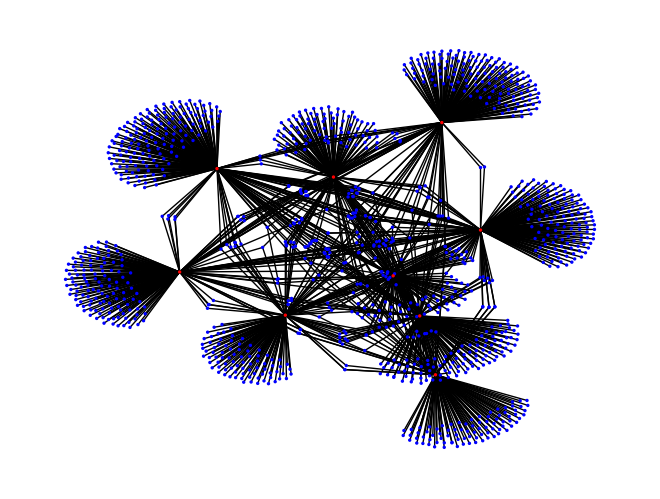

In [15]:
visualize_graph(df_ds, n=1500)

In [ ]:
G = nx.from_numpy_matrix(A)

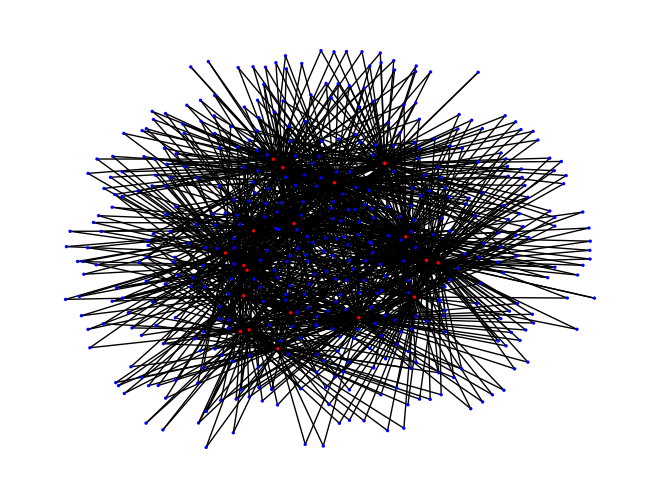

In [287]:
visualize_graph(df_ds_ft, n=2000)

In [286]:
df_ds_ft.groupby(se_label).count()

,STITCH,Side Effect Name,compound,se_idx
Individual Side Effect,,,,
C0001807,2,2,2,2
C0003132,3,3,0,3
C0003493,2,2,1,2
C0003621,2,2,2,2
C0003838,4,4,1,4
...,...,...,...,...
C2363801,3,3,1,3
C2363825,3,3,2,3
C2609421,3,3,0,3


In [285]:
df_ds_ft

,STITCH,Individual Side Effect,Side Effect Name,compound,se_idx
6,CID003062316,C0042023,pollakiuria,DB01254,6
8,CID003062316,C0744403,gingival infection,DB01254,8
12,CID003062316,C0340861,electromechanical dissociation,DB01254,12
16,CID003062316,C1141948,troponin increased,DB01254,16
24,CID003062316,C1112313,gastrointestinal mucosal disorder,DB01254,24
...,...,...,...,...,...
4116,CID000003386,C2979982,Vaginal haemorrhage,DB00472,126
4119,CID000003386,C0853314,soft tissue inflammation,DB00472,1916
4123,CID000003386,C0152965,staphylococcal bacteraemia,DB00472,1428
4130,CID000003386,C0037926,spinal cord compression,DB00472,1598


In [298]:
poi = df_ds
ss = poi.STITCH.unique()
se = poi[se_label].unique()
hs = []
for i in range(50):
    s1 = set(df_ds[df_ds[se_label]==se[i]].STITCH.unique())
    for j in range(i+1, 51):
        s2 = set(df_ds[df_ds[se_label]==se[j]].STITCH.unique())
        hs.append(len(s1.intersection(s2)))

    

<AxesSubplot: >

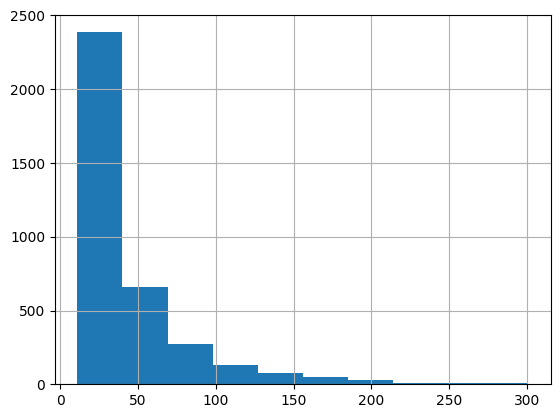

In [301]:
df_ds.groupby(se_label).count().STITCH.hist()

(array([191.,  86., 202.,  74., 115.,  51.,  48.,  53.,  26.,  59.,  30.,
         40.,  15.,  20.,  29.,  13.,  26.,  11.,  13.,  20.,   7.,  14.,
          5.,  13.,  10.,   4.,  11.,   7.,   9.,   4.,   4.,   2.,   2.,
          4.,   2.,   6.,   3.,   2.,   4.,   3.,   3.,   0.,   3.,   0.,
          1.,   1.,   2.,   4.,   0.,   2.,   2.,   1.,   0.,   1.,   2.,
          2.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  1.  ,   2.42,   3.84,   5.26,   6.68,   8.1 ,   9.52,  10.94,
         12.36,  13.78,  15.2 ,  16.62,  18.04,  19.46,  20.88,  22.3 ,
         23.72,  25.14,  26.56,  27.98,  29.4 ,  30.82,  32.24,  33.66,
         35.08,  36.5 ,  37.92,  39.34,  40.76,  42.18,  43.6 ,  45.02,
         46.44,  47.86,  49.28

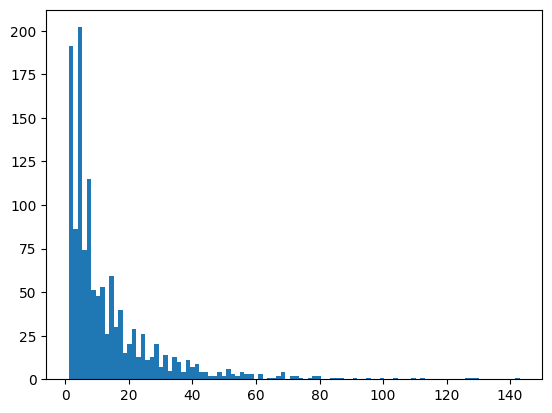

In [299]:
import matplotlib.pyplot as plt
plt.hist(hs, bins=100)